In [1]:
N = 3  # Number of analogues to each query spectrum
TEST_SLICE = -1  # set to -1 for full set

# SSMMCS parameters
SIMILARITY_THESHOLD = 0.2
NORMALIZE_WEIGHTS = True
# Morgan fingerprint parameters
MORGAN_RADIUS = 9
NBITS = 2048
USE_FEATURES = False
FPTYPE = "bv"  # "bv" (bitvector) or "count"

# FMCS parameters
TIMEOUT = 60

In [2]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [3]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [47]:
from typing import Callable
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFMCS


class MCSBenchmarkParams:
    """
    Class to hold parameters for MCS benchmarking.
    """

    def __init__(
        self, method_name: str = "mcs algorithm not defined", file_name: str = FILENAME
    ):
        self.method_name = method_name
        self.file_name = file_name

    def __str__(self) -> str:
        return f"file={self.file_name}"

    def __repr__(self) -> str:
        return self.__str__()


class SSMMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for SSMMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "SSMMCS",
        file_name: str = FILENAME,
        sim_map_threshold: float = SIMILARITY_THESHOLD,
        normalize_weigths: bool = NORMALIZE_WEIGHTS,
        fingerprint_function: str = "MORGAN",
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.fingerprint_function = fingerprint_function.upper()
        self.similarity_threshold = sim_map_threshold
        self.normalize_weights = normalize_weigths
        # MORGAN fingerprint parameters
        self.morgan_radius = MORGAN_RADIUS
        self.nbits = NBITS
        self.use_features = USE_FEATURES
        self.fp_type = FPTYPE

    def __str__(self) -> str:
        return f"SSMMCS-Benchmark_threshold={self.similarity_threshold}_normalize={self.normalize_weights}_{self.get_fingerprint_params()}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_fingerprint_params(self) -> str:
        param_string = f"fp={self.fingerprint_function}"

        if self.fingerprint_function == "MORGAN":
            return f"{param_string}_r={self.morgan_radius}_type={self.fp_type}_nBits={self.nbits}_useFeatures={self.use_features}"

        return f"{param_string}"

    def get_fingerprint_function(self, mol, atom_id, **kwargs) -> Callable:
        if self.fingerprint_function == "MORGAN":
            return SimilarityMaps.GetMorganFingerprint(
                mol,
                atom_id,
                radius=self.morgan_radius,
                fpType=self.fp_type,
                nBits=self.nbits,
                useFeatures=self.use_features,
                **kwargs,
            )
        elif self.fingerprint_function == "AP":
            return SimilarityMaps.GetAPFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "TT":
            return SimilarityMaps.GetTTFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "RDK":
            return SimilarityMaps.GetRDKFingerprint(mol, atom_id, **kwargs)
        else:
            raise ValueError(
                f"Unknown fingerprint function: {self.fingerprint_function}"
            )


class FMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for FMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "FMCS",
        file_name=FILENAME,
        params: rdFMCS.MCSParameters = rdFMCS.MCSParameters(),
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.params = params

    def __str__(self) -> str:
        atom_compare_params = self.get_atom_compare_parameters()
        bond_compare_params = self.get_bond_compare_parameters()
        base_params = self.get_base_parameters()
        return f"FMCS-Benchmark_{base_params}_{atom_compare_params}_{bond_compare_params}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_atom_compare_parameters(self) -> str:
        acp = self.params.AtomCompareParameters
        return f"ACCRO={int(acp.CompleteRingsOnly)}_ACRMRO={int(acp.RingMatchesRingOnly)}_MCT={int(acp.MatchChiralTag)}_MFC={int(acp.MatchFormalCharge)}_MI={int(acp.MatchIsotope)}_MV={int(acp.MatchValences)}_MD={acp.MaxDistance}"

    def get_bond_compare_parameters(self) -> str:
        bcp = self.params.BondCompareParameters
        return f"BCCRO={int(bcp.CompleteRingsOnly)}_BCRMRO={int(bcp.RingMatchesRingOnly)}_MFR={int(bcp.MatchFusedRings)}_MFRS={int(bcp.MatchFusedRingsStrict)}_MS={int(bcp.MatchStereo)}"

    def get_base_parameters(self) -> str:
        params = self.params
        return f"AT={int(params.AtomTyper)}_BT={int(params.BondTyper)}_TO={params.Timeout}_SA={int(params.StoreAll)}_MB={int(params.MaximizeBonds)}_TH={params.Threshold}"


class ChemSpaceExplorerBenchmarkParams:
    """
    Class to hold parameters for benchmarking on ChemSpaceExplorer results.
    """

    def __init__(
        self,
        n: int = N,
        test_slice: int = TEST_SLICE,
        method_params: MCSBenchmarkParams = SSMMCSBenchmarkParams(),
    ):
        self.n = n
        self.test_slice = test_slice
        self.method_params = method_params

    def __str__(self) -> str:
        if self.test_slice >= 0:
            return f"CSE_n={self.n}_slice={self.test_slice}_{self.method_params}"

        return f"CSE_n={self.n}-{self.method_params}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_method_params(self):
        if self.method_params is SSMMCSBenchmarkParams:
            return SSMMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                sim_map_threshold=self.method_params.sim_map_threshold,
                normalize_weigths=self.method_params.normalize_weights,
                fingerprint_function=self.method_params.fingerprint_function,
            )
        elif self.method_params is FMCSBenchmarkParams:
            return FMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                params=self.method_params.params,
            )

    def get_data_slice(self, data):
        if self.test_slice >= 0:
            return data[: self.test_slice]

        return data

# Chemspace Explorer Initialization

In [5]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 237.81it/s]


In [6]:
def analogue_search(n: int = 2):
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        explorer = start_workflow(
            os.path.abspath(
                os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)
            )
        )
        analogues = explorer.analogue_search(query_spectra, n=n)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [7]:
import pandas as pd

analogues_df = analogue_search(n=N)

Loaded analogues from pickle\results_n=3.pkl


In [8]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols


def generate_analogue_mols(dataFrame: pd.DataFrame):
    file = os.path.join(
        PICKLE,
        f"n={N}_analogue_dataframe_with_{len(query_spectra)*N}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [9]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

analogues_df = generate_analogue_mols(analogues_df)

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl
Loaded dataframe with 1806 analogues from pickle\n=3_analogue_dataframe_with_1809_mols_for_1000_test_spectra.mgf.pkl


In [10]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)
assert analogues_df["query_spectrum_id"].nunique() == len(query_spectra)
assert len(analogues_df) >= len(query_spectra)
assert len(analogues_df) <= len(query_spectra) * N

len(query_spectra) * N

1809

In [11]:
def chemspace_explorer_benchmark(
    query_mols, params: ChemSpaceExplorerBenchmarkParams, method: Callable
):
    filename = f"{len(query_mols)}_results_for_{params.method_params}.csv"
    # Sanitize the whole filename again just to be safe
    filename = sanitize_filename(filename)
    file = os.path.join(DATA_FOLDER, filename)

    if os.path.exists(file):
        df = pd.read_csv(file)
        print(
            f"Loaded {len(df)} {params.method_params.method_name} results from {file}."
        )
    else:
        try:
            print(f"Running {params.method_params.method_name}...")
            df = method(query_mols, params.method_params)

            if len(df) == 0:
                print(f"No results for {params.method_params}.")
                return None

            # Save CSV once after all processing is complete
            os.makedirs(os.path.dirname(file), exist_ok=True)
            df.to_csv(file, index=False)
            print(
                f"Saved {len(df)} {params.method_params.method_name} results to {file}."
            )
        except Exception as e:
            print(f"Error during {params.method_params.method_name} processing: {e}")
            return None

    return df


def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [12]:
def get_query_analogues(query_id: int):
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

# FMCS

In [13]:
import time


def benchmark_fmcs(query_mols, fmcs_params: FMCSBenchmarkParams):
    fmcs_df = pd.DataFrame(
        columns=[
            "query_id",
            "matched",
            "failed",
            "time",
            "mcs_size",
            "mcs_smarts",
            "query_match",
            "degenerate_smarts",
        ]
    )

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc="Benchmarking FMCS"
    ):
        try:
            query_analogues = get_query_analogues(query_id)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue

            start_time = time.time()
            fmcs = rdFMCS.FindMCS(query_analogues, fmcs_params.params)
            elapsed_time = time.time() - start_time

            matched = False
            query_match = None
            smartsString = None
            degenerate_smarts = None

            if fmcs_params.params.StoreAll:
                print(
                    f"Found {len(fmcs.degenerateSmartsQueryMolDict)} degenerate MCSes for query {query_id}."
                )
                degenerate_smarts = []
                for smarts, mcs in fmcs.degenerateSmartsQueryMolDict.items():
                    # only update match result, if we haven't found a match yet
                    if not matched:
                        degenerate_mcs_match = query_mol.GetSubstructMatch(mcs)
                        degenerate_mcs_matched = len(degenerate_mcs_match) > 0

                        if degenerate_mcs_matched:
                            query_match = degenerate_mcs_match
                            smartsString = smarts
                            matched = True

                    # only store additional smarts to the matched smarts
                    if smartsString != smarts:
                        degenerate_smarts.append(smarts)

            else:
                query_match = query_mol.GetSubstructMatch(fmcs.queryMol)
                matched = len(query_match) > 0
                smartsString = fmcs.smartsString

            aborted = fmcs.canceled

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "matched": matched,
                "failed": aborted,
                "time": elapsed_time,
                "mcs_size": fmcs.numAtoms,
                "mcs_smarts": smartsString,
                "query_match": query_match if matched else None,
                "degenerate_smarts": degenerate_smarts,
            }
            fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return fmcs_df

In [14]:
rdfmcs_params = rdFMCS.MCSParameters()
rdfmcs_params.AtomTyper = rdFMCS.AtomCompare.CompareElements
rdfmcs_params.BondTyper = rdFMCS.BondCompare.CompareOrderExact
rdfmcs_params.AtomCompareParameters.RingMatchesRingOnly = True
rdfmcs_params.Timeout = TIMEOUT

fmcs_params = FMCSBenchmarkParams(params=rdfmcs_params)
cse_fmcs_params = ChemSpaceExplorerBenchmarkParams(method_params=fmcs_params)

# Create sanitized parameter string first
fmcs_df = chemspace_explorer_benchmark(
    query_mols, cse_fmcs_params, method=benchmark_fmcs
)

Running FMCS...


Benchmarking FMCS:   0%|          | 0/603 [00:00<?, ?it/s]

C:\Users\kevin\AppData\Local\Temp\ipykernel_17992\785843244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)


Skipping query 564 due to insufficient number of analogues!
Saved 602 FMCS results to data\603_results_for_FMCS-Benchmark_AT=1_BT=2_TO=60_SA=0_MB=1_TH=1.0_ACCRO=0_ACRRO=1_MCT=0_MFC=0_MI=0_MV=0_MD=-1.0_BCCRO=0_BCRRO=0_MFR=0_MFRS=0_MS=0_file=1000_test_spectra.mgf.csv.


In [15]:
fmcs_df

,query_id,matched,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
0,0,True,False,0.008003,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",None
1,1,True,False,0.011999,10,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#8]-[#6]-[#6](-[...,"(7, 8, 9, 30, 10, 18, 25, 31, 19, 26)",None
2,2,True,False,0.711001,22,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#6](-[#8&!R])-[#...,"(8, 7, 5, 9, 6, 4, 15, 10, 3, 16, 17, 18, 19, ...",None
3,3,True,False,0.002001,20,[#6]1-[#6]2:[#6](-[#8&!R]):[#6]:[#6](:[#6]:[#6...,"(2, 3, 1, 4, 10, 12, 0, 5, 6, 9, 11, 13, 7, 14...",None
4,4,False,False,0.015997,15,[#6]1-[#6]-[#6]-[#6]-[#6]2-[#6]-1(-[#6]-[#6]-[...,None,None
...,...,...,...,...,...,...,...,...
597,598,False,False,0.180996,15,[#8&!R]=[#6]1:[#6]:[#6]:[#8]:[#6]2:[#6]:1:[#6]...,None,None
598,599,False,False,0.811000,19,[#8&!R]=[#6]1:[#6]:[#6](:[#8]:[#6]2:[#6]:1:[#6...,None,None
599,600,False,False,0.103999,21,[#8&!R]-[#6]1:[#6]2:[#6](:[#8]:[#6]3:[#6](:[#6...,None,None
600,601,False,False,0.000000,19,[#6]1-[#6]-[#7](-[#6]-[#6]-[#7]-1)-[#6&!R](-[#...,None,None


# SSMMCS

In [16]:
from rdkit.Chem.Draw import SimilarityMaps


def get_stacked_sim_map_fragments_and_weights(
    mols: list[Chem.Mol],
    fp_function: Callable = SimilarityMaps.GetMorganFingerprint,
    similarity_threshold: float = SIMILARITY_THESHOLD,
    normalize_stacked_weights: bool = NORMALIZE_WEIGHTS,
) -> tuple[list[Chem.Mol], list[list[float]]]:

    stacked_weights = []
    all_analogue_fragments = []

    for ref_mol in mols:
        ref_mol_smiles = Chem.MolToSmiles(ref_mol)
        ref_mol_stacked_weights = [0] * ref_mol.GetNumAtoms()
        for probe_mol in mols:
            probe_mol_smiles = Chem.MolToSmiles(probe_mol)
            # Skip if comparing molecule to itself
            if probe_mol_smiles == ref_mol_smiles:
                continue

            # extract similarity weights for the reference molecule
            sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(
                probe_mol, ref_mol, fp_function
            )
            sim_weights, _ = SimilarityMaps.GetStandardizedWeights(sim_weights)

            assert (
                len(sim_weights) == ref_mol.GetNumAtoms()
            ), "Length of sim_weights does not match number of atoms in reference molecule."
            # stack the weights
            ref_mol_stacked_weights = [
                ref_mol_stacked_weights[i] + sim_weights[i]
                for i in range(ref_mol.GetNumAtoms())
            ]

        if normalize_stacked_weights:
            ref_mol_stacked_weights, _ = SimilarityMaps.GetStandardizedWeights(
                ref_mol_stacked_weights
            )

        stacked_weights.append(ref_mol_stacked_weights)

        # Extract fragments from the reference molecule using the similarity weights
        analogue_fragments = extract_sim_map_fragments_from_mol(
            ref_mol, ref_mol_stacked_weights, similarity_threshold
        )
        all_analogue_fragments.extend(analogue_fragments)

    return all_analogue_fragments, stacked_weights


def find_SSMMCS_and_SSMMSS(
    mols: list[Chem.Mol], substruct_candidates: list[Chem.Mol], min_num_atoms: int = 2
) -> tuple[Chem.Mol | None, Chem.Mol | None]:

    common_substructs = []
    unique_smiles = set()
    mcs_id = -1
    mcs_size = 0
    mss = None
    mss_size = 0

    for substruct in substruct_candidates:
        num_Atoms = substruct.GetNumAtoms()

        # skip substructs below atom threshold
        if num_Atoms < min_num_atoms:
            continue

        # skip duplicates
        smiles = Chem.MolToSmiles(substruct)
        if smiles in unique_smiles:
            continue
        unique_smiles.add(smiles)

        # find the maximum stacked substructure (MSS)
        if num_Atoms > mss_size:
            mss = substruct
            mss_size = num_Atoms

        # find the maximum common substructure (MCS)
        is_common = True
        for analogue in mols:
            if len(analogue.GetSubstructMatch(substruct)) <= 0:
                is_common = False
                break

        if not is_common:
            continue
        common_substructs.append(substruct)

        if num_Atoms > mcs_size:
            mcs_id = len(common_substructs) - 1
            mcs_size = num_Atoms

        # if MSS and MCS are the same size, update MSS to MCS
        if num_Atoms == mss_size:
            mss = common_substructs[mcs_id]

    if mcs_id < 0:
        mcs = None
    else:
        mcs = common_substructs[mcs_id]

    return mcs, mss


def extract_sim_map_fragments_from_mol(
    mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> list[Chem.Mol]:

    visited = set()
    fragment_mols = []

    # Iterate through all atoms to find connected_atoms
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if (
            atom_idx not in visited
            and similarity_weights[atom_idx] >= similarity_threshold
        ):
            connected_atoms = find_connected_atoms_recursive(
                atom_idx, visited, mol, similarity_weights, similarity_threshold
            )
            if connected_atoms:
                # Create a new molecule for this connected_atoms
                fragment = Chem.RWMol(mol)

                # Create a map of atoms to remove (those not in connected_atoms)
                atoms_to_remove = set(range(mol.GetNumAtoms())) - connected_atoms

                # Remove atoms not in connected_atoms (remove in reverse order to preserve indices)
                for remove_idx in sorted(atoms_to_remove, reverse=True):
                    fragment.RemoveAtom(remove_idx)

                # Convert to regular molecule and add to list
                fragment_mols.append(fragment.GetMol())

    return fragment_mols


def find_connected_atoms_recursive(
    atom_idx: int,
    visited: set[int],
    mol: Chem.Mol,
    similarity_weights: list[float],
    similarity_threshold: float,
) -> set[int]:
    if atom_idx in visited or similarity_weights[atom_idx] < similarity_threshold:
        return set()

    atoms = {atom_idx}
    visited.add(atom_idx)

    # Get current atom object
    atom = mol.GetAtomWithIdx(atom_idx)

    # Iterate through bonds to neighboring atoms
    for bond in atom.GetBonds():
        # Get the neighboring atom's index
        neighbor_idx = (
            bond.GetBeginAtomIdx()
            if bond.GetEndAtomIdx() == atom_idx
            else bond.GetEndAtomIdx()
        )

        if similarity_weights[neighbor_idx] >= similarity_threshold:
            atoms.update(
                find_connected_atoms_recursive(
                    neighbor_idx, visited, mol, similarity_weights, similarity_threshold
                )
            )

    return atoms
def FindSSMMCS(mols, params: SSMMCSBenchmarkParams):
    all_analogue_fragments, _ = get_stacked_sim_map_fragments_and_weights(
        mols=mols,
        fp_function=params.get_fingerprint_function,
        similarity_threshold=params.similarity_threshold,
        normalize_stacked_weights=params.normalize_weights,
    )

    return find_SSMMCS_and_SSMMSS(mols, all_analogue_fragments, min_num_atoms=2)

In [17]:
import time


def benchmark_ssmmcs(query_mols, ssmmcs_params: SSMMCSBenchmarkParams):
    ssmmcs_df = pd.DataFrame(
        columns=[
            "query_id",
            "matched_mcs",
            "matched_mss",
            "failed",
            "time",
            "mcs_size",
            "mcs_smarts",
            "mss_size",
            "mss_smarts",
        ]
    )

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc="Benchmarking SSMMMCS"
    ):
        try:
            query_analogues = get_query_analogues(query_id)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue
            start_time = time.time()
            mcs, mss = FindSSMMCS(
                query_analogues, ssmmcs_params
            )  # MorganWrapper, SIM_MAP_THESHOLD, NORMALIZE_WEIGHTS)
            elapsed_time = time.time() - start_time

            if mcs is None:
                matched_mcs = False
                query_match_mcs = None
                mcs_size = 0
                mcs_smarts = ""
            else:
                query_match_mcs = query_mol.GetSubstructMatch(mcs)
                matched_mcs = len(query_match_mcs) > 0
                mcs_size = mcs.GetNumAtoms()
                mcs_smarts = Chem.MolToSmarts(mcs)

            if mss is None:
                matched_mss = False
                query_match_mss = None
                mss_size = 0
                mss_smarts = ""
            else:
                query_match_mss = query_mol.GetSubstructMatch(mss)
                matched_mss = len(query_match_mss) > 0
                mss_size = mss.GetNumAtoms()
                mss_smarts = Chem.MolToSmarts(mss)

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "matched_mcs": matched_mcs,
                "matched_mss": matched_mss,
                "failed": not matched_mcs and not matched_mss,
                "time": elapsed_time,
                "mcs_size": mcs_size,
                "mcs_smarts": mcs_smarts,
                "mss_size": mss_size,
                "mss_smarts": mss_smarts,
                "query_match_mcs": query_match_mcs,
                "query_match_mss": query_match_mss,
            }
            ssmmcs_df = pd.concat(
                [ssmmcs_df, pd.DataFrame([new_row])], ignore_index=True
            )
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return ssmmcs_df

In [18]:
ssmmcs_params = SSMMCSBenchmarkParams(
    method_name="SSMMCS",
    file_name=FILENAME,
    sim_map_threshold=SIMILARITY_THESHOLD,
    normalize_weigths=NORMALIZE_WEIGHTS,
    fingerprint_function="morgan",
)

cse_ssmmcs_params = ChemSpaceExplorerBenchmarkParams(method_params=ssmmcs_params)

ssmmcs_df = chemspace_explorer_benchmark(
    query_mols, params=cse_ssmmcs_params, method=benchmark_ssmmcs
)


ssmmcs_df

Running SSMMCS...


Benchmarking SSMMMCS:   0%|          | 0/603 [00:00<?, ?it/s]

C:\Users\kevin\AppData\Local\Temp\ipykernel_17992\2756696462.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ssmmcs_df = pd.concat(


Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.


,query_id,matched_mcs,matched_mss,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
0,0,True,False,False,0.196000,41,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",()
1,1,True,True,False,0.112999,11,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,32,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 25, 26, ..."
2,2,True,True,False,0.071004,5,[#6]-[#6]-[#8]-[#6]:[#6],18,[#6]-[#6]1:[#6]:[#6](:[#6](:[#6]:[#8]:1):[#6]:...,"(4, 16, 17, 18, 19)","(23, 22, 24, 25, 27, 20, 18, 17, 16, 4, 3, 1, ..."
3,3,True,True,False,0.049002,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
4,4,False,False,True,0.029001,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,10,[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]-[#6]...,(),()
...,...,...,...,...,...,...,...,...,...,...,...
597,598,False,False,True,0.051000,3,[#6](:[#6])-[#6@@H],18,[#6]1:[#6](:[#6](-[#8]):[#6]):[#6](:[#6]):[#8]...,(),()
598,599,False,False,True,0.079002,11,[#6]-[#8]-[#6]1-[#8]-[#6]-[#6](-[#8])-[#6](-[#...,11,[#6]-[#8]-[#6]1-[#8]-[#6]-[#6](-[#8])-[#6](-[#...,(),()
599,600,False,False,True,0.036002,0,,16,[#6]1:[#6]2:[#6](:[#8]:[#6]:[#6](:[#6]):[#6]:2...,None,()
600,601,False,False,True,0.022998,19,[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#6]1...,19,[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-1)-[#6](-[#6]1...,(),()


In [19]:
fmcs_df["time"].sum(), ssmmcs_df["time"].sum()

(2345.551613807678, 35.81891965866089)

# Overall Benchmark results

In [21]:
fmcs_df.mcs_size.mean(), ssmmcs_df.mcs_size.mean(), fmcs_df.mcs_size.std(), ssmmcs_df.mcs_size.std()

(16.767441860465116, 10.192691029900333, 11.169354456241413, 8.355022585061702)

In [22]:
ssmmcs_df.mss_size.mean(), ssmmcs_df.mss_size.std()

(17.86046511627907, 12.956620255126454)

In [40]:
fmcs_df.matched.sum() / len(fmcs_df), ssmmcs_df.matched_mcs.sum() / len(ssmmcs_df)

(0.3222591362126246, 0.49667774086378735)

In [24]:
fmcs_df[fmcs_df["matched"] == True]

,query_id,matched,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
0,0,True,False,0.008003,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",None
1,1,True,False,0.011999,10,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#8]-[#6]-[#6](-[...,"(7, 8, 9, 30, 10, 18, 25, 31, 19, 26)",None
2,2,True,False,0.711001,22,[#8&!R]-[#6]1-[#6](-[#8&!R])-[#6](-[#8&!R])-[#...,"(8, 7, 5, 9, 6, 4, 15, 10, 3, 16, 17, 18, 19, ...",None
3,3,True,False,0.002001,20,[#6]1-[#6]2:[#6](-[#8&!R]):[#6]:[#6](:[#6]:[#6...,"(2, 3, 1, 4, 10, 12, 0, 5, 6, 9, 11, 13, 7, 14...",None
5,5,True,False,0.002000,10,[#16&!R](=[#8&!R])(=[#8&!R])-[#6]1:[#6]:[#6]:[...,"(13, 14, 15, 16, 17, 22, 18, 21, 19, 20)",None
...,...,...,...,...,...,...,...,...
583,584,True,False,0.001000,4,[#8&!R]-[#6&R]:[#6&R]:[#6&R],"(4, 3, 2, 9)",None
585,586,True,False,0.002001,8,[#17&!R]-[#6]1:[#6]:[#6](-[#17&!R]):[#6]:[#6]:...,"(20, 17, 16, 18, 15, 19, 21, 14)",None
586,587,True,False,0.001998,7,[#6&R](:[#6&R]:[#6&R](:[#6&R])-[#6&R]):[#6&R]:...,"(4, 20, 5, 8, 6, 7, 9)",None
587,588,True,False,0.001001,19,[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#6&!R](-[#...,"(9, 8, 10, 7, 11, 12, 6, 13, 5, 14, 18, 4, 15,...",None


In [25]:
ssmmcs_df[ssmmcs_df["matched_mcs"] == True]

,query_id,matched_mcs,matched_mss,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
0,0,True,False,False,0.196000,41,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",()
1,1,True,True,False,0.112999,11,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,32,[#6]-[#6]-[#6](=[#8])-[#8]-[#6@@H]1-[#6@H](-[#...,"(32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)","(3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 25, 26, ..."
2,2,True,True,False,0.071004,5,[#6]-[#6]-[#8]-[#6]:[#6],18,[#6]-[#6]1:[#6]:[#6](:[#6](:[#6]:[#8]:1):[#6]:...,"(4, 16, 17, 18, 19)","(23, 22, 24, 25, 27, 20, 18, 17, 16, 4, 3, 1, ..."
3,3,True,True,False,0.049002,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,19,[#6]1:[#6](-[#8]):[#6]:[#6](-[#8]):[#6]:[#6]:1...,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
5,5,True,False,False,0.050996,8,[#16]-[#6]1:[#6]:[#6]:[#6](-[#6]):[#6]:[#6]:1,18,[#6]-[#6]1:[#6]:[#6]:[#6](-[#16](=[#8])(=[#8])...,"(13, 16, 17, 18, 19, 20, 21, 22)",()
...,...,...,...,...,...,...,...,...,...,...,...
586,587,True,True,False,0.036998,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,8,[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(4, 5, 6, 7, 8, 20)","(8, 9, 10, 11, 12, 13, 14, 19)"
587,588,True,True,False,0.019000,16,[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#6](-[#6]1...,16,[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-[#6](-[#6]1...,"(9, 8, 7, 12, 11, 10, 6, 13, 14, 15, 16, 17, 1...","(9, 8, 7, 12, 11, 10, 6, 13, 14, 15, 16, 17, 1..."
588,589,True,True,False,0.023000,5,[#6]:[#6]:[#6](=[#8]):[#8],6,[#6]-[#8]-[#6]:[#6]-[#8]-[#6],"(8, 9, 10, 11, 12)","(0, 1, 2, 3, 25, 26)"
592,593,True,False,False,0.208000,5,[#6]-[#6]-[#6]-[#6]-[#6],57,[#8]-[#6]1-[#6]-[#8]-[#6](-[#8]-[#6]2-[#6]-[#6...,"(1, 3, 50, 63, 65)",()


In [26]:
ssmmcs_df.matched_mcs.sum(), ssmmcs_df.matched_mss.sum()

(299, 151)

In [27]:
# show all fmcs queries where ssmmcs failed
fmcs_df[(fmcs_df["matched"] == True) & (ssmmcs_df["matched_mcs"] == False)]

,query_id,matched,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
12,12,True,False,0.001001,8,[#6&!R]-[#6&!R]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(7, 6, 3, 2, 4, 1, 5, 0)",None
37,37,True,False,0.000000,2,[#6&!R]-[#6&!R],"(0, 1)",None
150,150,True,False,0.001001,7,[#16&!R](=[#8&!R])(=[#8&!R])-[#6&R](:[#6&R]):[...,"(7, 8, 9, 10, 11, 18, 17)",None
239,239,True,False,0.002001,8,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6&!R]-[#6...,"(8, 7, 9, 6, 10, 5, 1, 2)",None
241,241,True,False,0.049000,17,[#8&!R]=[#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2...,"(0, 1, 2, 14, 3, 10, 13, 15, 4, 8, 11, 20, 16,...",None
306,306,True,False,0.001000,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,"(17, 18, 22, 19, 21, 20)",None
315,315,True,False,0.000000,2,[#6&!R]-[#8&!R],"(4, 5)",None
317,317,True,False,0.001002,6,[#6&!R]-[#6&R](-[#6&R]-[#6&R])-[#6&R]-[#6&R],"(10, 9, 8, 13, 7, 4)",None
343,343,True,True,60.711000,30,[#6&R](-[#6&R]-[#6&R]-[#6&R](-[#6&R]-[#6&R])-[...,"(26, 27, 25, 28, 23, 18, 24, 22, 17, 19, 16, 1...",None
348,348,True,False,0.008000,14,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6&R]:[#6&...,"(23, 22, 26, 21, 27, 20, 19, 18, 4, 3, 9, 7, 6...",None


In [28]:
# and vice versa
ssmmcs_df[(ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == False)]

,query_id,matched_mcs,matched_mss,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
7,7,True,False,False,0.041997,6,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1,9,[#6]:[#6]1:[#6]:[#8]:[#6]:[#6](-[#6]):[#6]:1=[#8],"(1, 2, 3, 4, 29, 30)",()
9,9,True,False,False,0.042998,2,[#6]=[#8],15,[#8]=[#6](-[#7]-[#6](:[#6]):[#6])-[#6](:[#6]:[...,"(6, 8)",()
14,14,True,True,False,0.013004,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,9,[#6](-[#6@H](-[#6@H](-[#6@H])-[#8])-[#8])-[#8]...,"(5, 4, 3, 2, 13, 12, 7, 8, 9)","(5, 4, 3, 2, 13, 12, 7, 8, 9)"
16,16,True,False,False,0.062999,2,[#6]:[#6],26,[#8]=[#6](-[#7]-[#6]1:[#7]:[#6]:[#6]:[#16]:1)-...,"(3, 4)",()
23,23,True,False,False,0.062002,3,[#6]-[#6]-[#8],7,[#6]-[#6](-[#6])=[#6]-[#6](-[#8])-[#6],"(6, 7, 9)",()
...,...,...,...,...,...,...,...,...,...,...,...
578,579,True,True,False,0.005997,4,[#6]-[#6]-[#6]=[#8],4,[#6]-[#6]-[#6]=[#8],"(5, 4, 9, 10)","(5, 4, 9, 10)"
582,583,True,False,False,0.274003,12,[#8]-[#6]1-[#8]-[#6](-[#6]-[#8])-[#6](-[#8])-[...,77,[#6]-[#6]1-[#8]-[#6](-[#8]-[#6]-[#6]-[#6]-[#6]...,"(12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)",()
584,585,True,False,False,0.186000,3,[#6]-[#6]-[#6],61,[#6]-[#8]-[#6]1-[#6](-[#8])-[#6](-[#8]-[#6]2-[...,"(0, 1, 2)",()
592,593,True,False,False,0.208000,5,[#6]-[#6]-[#6]-[#6]-[#6],57,[#8]-[#6]1-[#6]-[#8]-[#6](-[#8]-[#6]2-[#6]-[#6...,"(1, 3, 50, 63, 65)",()


In [29]:
# show the mcs size difference between ssmmcs and fmcs
mask = (ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == True)
botch_mathed = ssmmcs_df.loc[mask, "mcs_size"] - fmcs_df.loc[mask, "mcs_size"]
botch_mathed.mean(), botch_mathed.std(), botch_mathed.min(), botch_mathed.max()

(-3.9881656804733727, 5.226976916600293, -30, 6)

In [45]:
mask = ssmmcs_df["mcs_size"] == 0
ssmmcs_df[mask]

,query_id,matched_mcs,matched_mss,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss
37,37,False,False,True,0.004000,0,NaN,8,[#8]=[#6](-[#8])-[#6](=[#8])-[#6](=[#8])-[#8],NaN,()
84,84,False,False,True,0.070999,0,NaN,14,[#6]1:[#8]:[#6](=[#8]):[#6]2:[#6](-[#6]-[#6]-[...,NaN,()
103,103,False,False,True,0.027004,0,NaN,21,[#8]=[#6]1:[#6](-[#8]):[#6](-[#6]2:[#6]:[#6]:[...,NaN,()
121,121,False,False,True,0.031004,0,NaN,8,[#8]-[#6]1:[#6]:[#6]:[#6](-[#7]):[#6]:[#6]:1,NaN,()
135,135,False,False,True,0.130001,0,NaN,45,[#6](-[#6@H](-[#8]-[#6](-[#6]-[#6]-[#6]-[#6]-[...,NaN,()
146,146,False,False,True,0.027999,0,NaN,21,[#8]-[#6]1:[#6]:[#6](-[#8]):[#6]2:[#6](:[#6]:1...,NaN,()
150,150,False,False,True,0.032999,0,NaN,21,[#8]=[#6](-[#8])-[#6]1:[#6]:[#6](-[#16](=[#8])...,NaN,()
157,157,False,False,True,0.025998,0,NaN,20,[#6](-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](...,NaN,()
168,168,False,False,True,0.167999,0,NaN,58,[#6]/[#6]=[#6]\[#6]/[#6]=[#6]\[#6]/[#6]=[#6]\[...,NaN,()
169,169,False,False,True,0.127999,0,NaN,45,[#6](-[#6@H](-[#8]-[#6](-[#6]-[#6]-[#6]-[#6]-[...,NaN,()


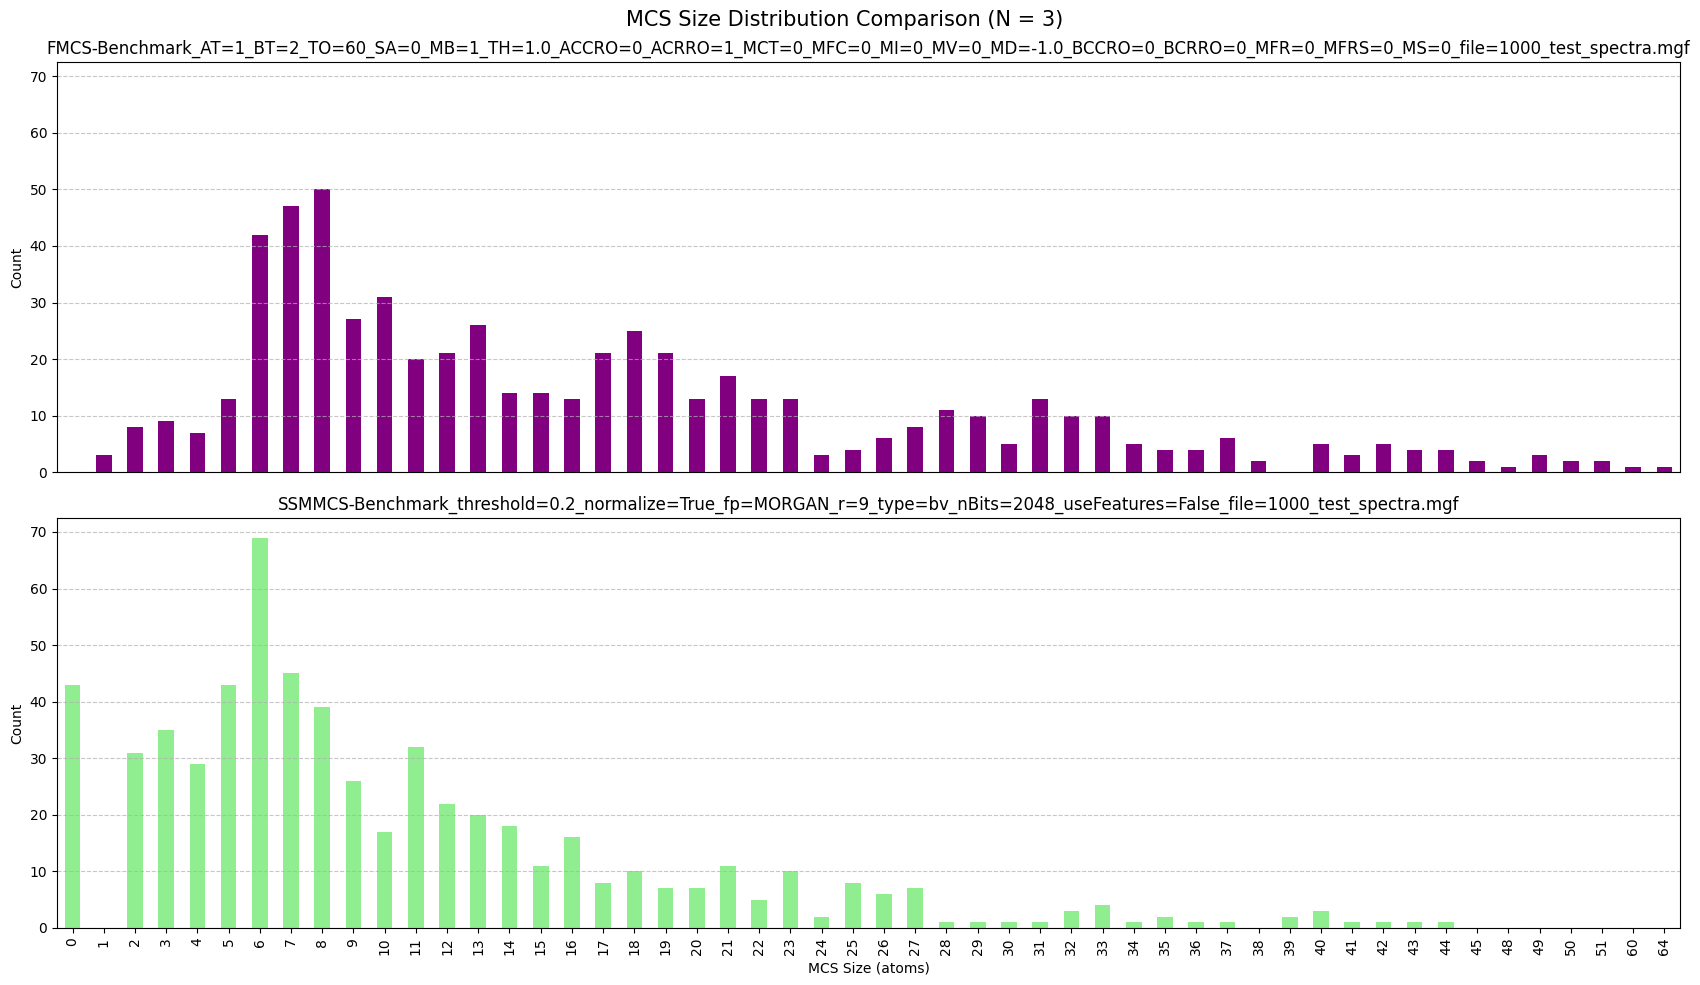

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Get all unique MCS sizes that appear in either dataframe
all_sizes = sorted(
    set(fmcs_df["mcs_size"].unique()) | set(ssmmcs_df["mcs_size"].unique())
)

# Create Series with counts for each size, including zeros for missing values
fmcs_counts = (
    fmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()
)
ssmmcs_counts = (
    ssmmcs_df["mcs_size"].value_counts().reindex(all_sizes, fill_value=0).sort_index()
)

# Calculate the maximum count value across both distributions
max_count = max(fmcs_counts.max(), ssmmcs_counts.max())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))
fig.suptitle(f"MCS Size Distribution Comparison (N = {cse_fmcs_params.n})", fontsize=15)

# Plot FMCS distribution with consistent x-axis
fmcs_counts.plot(
    kind="bar",
    ax=ax1,
    title=cse_fmcs_params.method_params.__str__(),
    color="purple",  # Set color for FMCS bars
)
ax1.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax1.set_xticks([])
ax1.set_xlabel("")
ax1.set_ylabel("Count")
ax1.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

# Plot SSMMCS distribution with consistent x-axis
ssmmcs_counts.plot(
    kind="bar",
    ax=ax2,
    title=cse_ssmmcs_params.method_params.__str__(),
    color="lightgreen",  # Set color for SSMMCS bars
)
ax2.set_ylim(0, max_count * 1.05)  # Add 5% padding
ax2.set_xlabel("MCS Size (atoms)")
ax2.set_ylabel("Count")
ax2.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_distribution_comparison_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

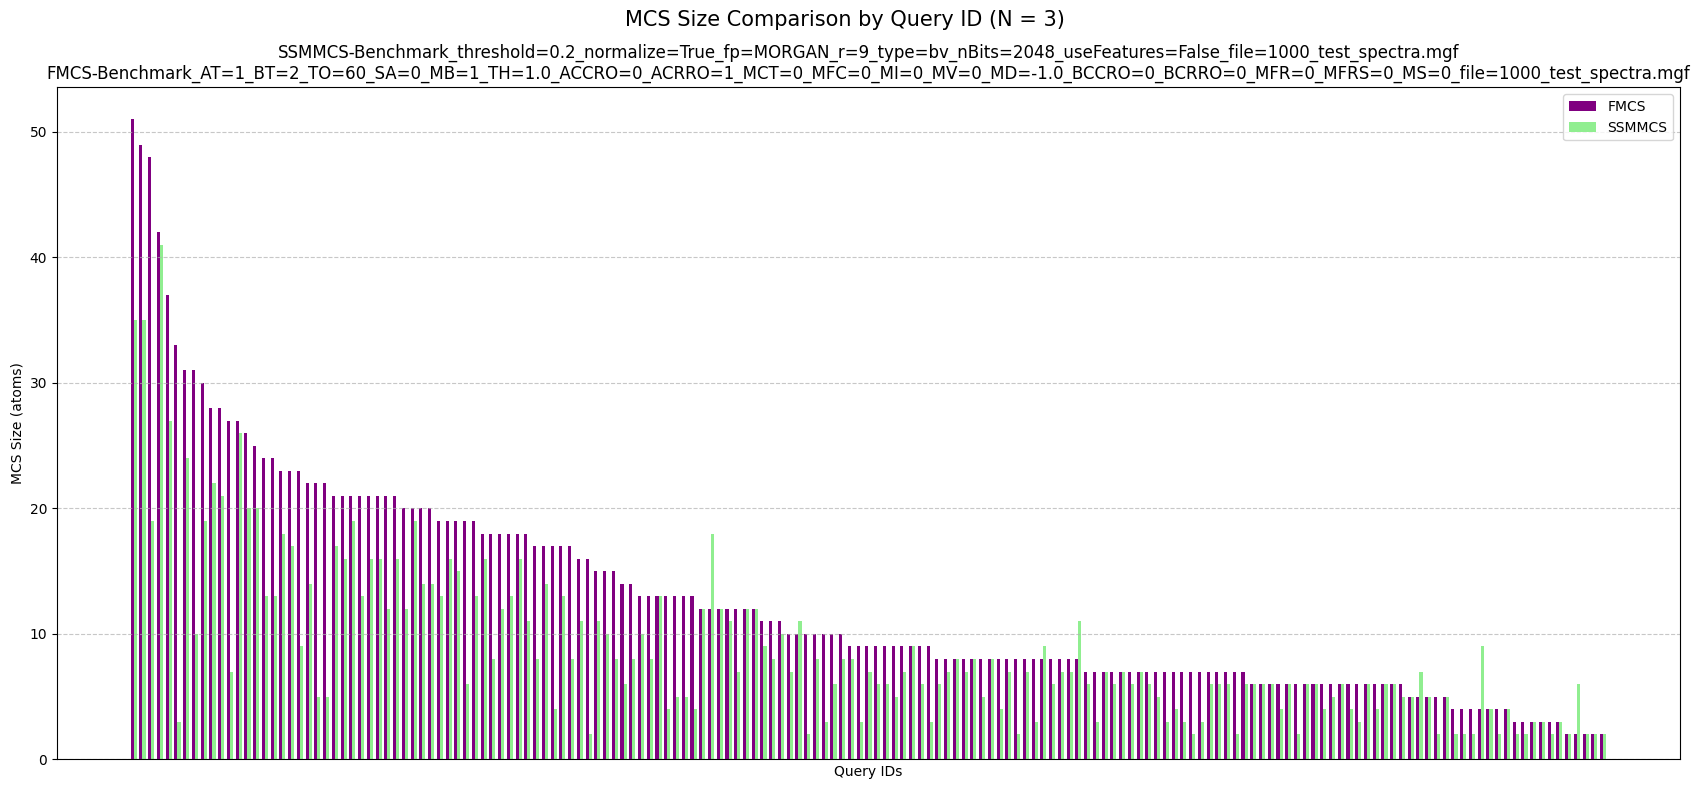

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# 1. First get all query IDs where both methods found a match
mask = (ssmmcs_df["matched_mcs"] == True) & (fmcs_df["matched"] == True)
matched_query_ids = fmcs_df[mask]["query_id"].unique()

# 2. Create a dataframe to hold the comparison data
comparison_df = pd.DataFrame({"query_id": [], "fmcs_size": [], "ssmmcs_size": []})

# 3. Populate the comparison dataframe
for qid in matched_query_ids:
    fmcs_size = fmcs_df[fmcs_df["query_id"] == qid]["mcs_size"].values[0]
    ssmmcs_size = ssmmcs_df[ssmmcs_df["query_id"] == qid]["mcs_size"].values[0]
    comparison_df = pd.concat(
        [
            comparison_df,
            pd.DataFrame(
                {
                    "query_id": [qid],
                    "fmcs_size": [fmcs_size],
                    "ssmmcs_size": [ssmmcs_size],
                    "difference": [ssmmcs_size - fmcs_size],
                }
            ),
        ],
        ignore_index=True,
    )

comparison_df = comparison_df.sort_values("fmcs_size", ascending=False)

# Setting up the bar chart with side-by-side bars
bar_width = 0.35
x = np.arange(len(comparison_df))

fig, ax = plt.subplots(figsize=(17, 8))

# Creating the bars
bar1 = ax.bar(
    x - bar_width / 2,
    comparison_df["fmcs_size"],
    bar_width,
    label="FMCS",
    color="purple",
)
bar2 = ax.bar(
    x + bar_width / 2,
    comparison_df["ssmmcs_size"],
    bar_width,
    label="SSMMCS",
    color="lightgreen",
)

# Add labels, title and legend
ax.set_xlabel("Query IDs")
ax.set_ylabel("MCS Size (atoms)")
fig.suptitle(f"MCS Size Comparison by Query ID (N = {cse_fmcs_params.n})", fontsize=15)
ax.set_title(f"{cse_ssmmcs_params.method_params.__str__()}\n{cse_fmcs_params.method_params.__str__()}")
ax.set_xticks([])
ax.grid(axis="y", linestyle="--", alpha=0.7)  # Add y-axis grid lines

ax.legend()

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_comparison_by_query_id_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

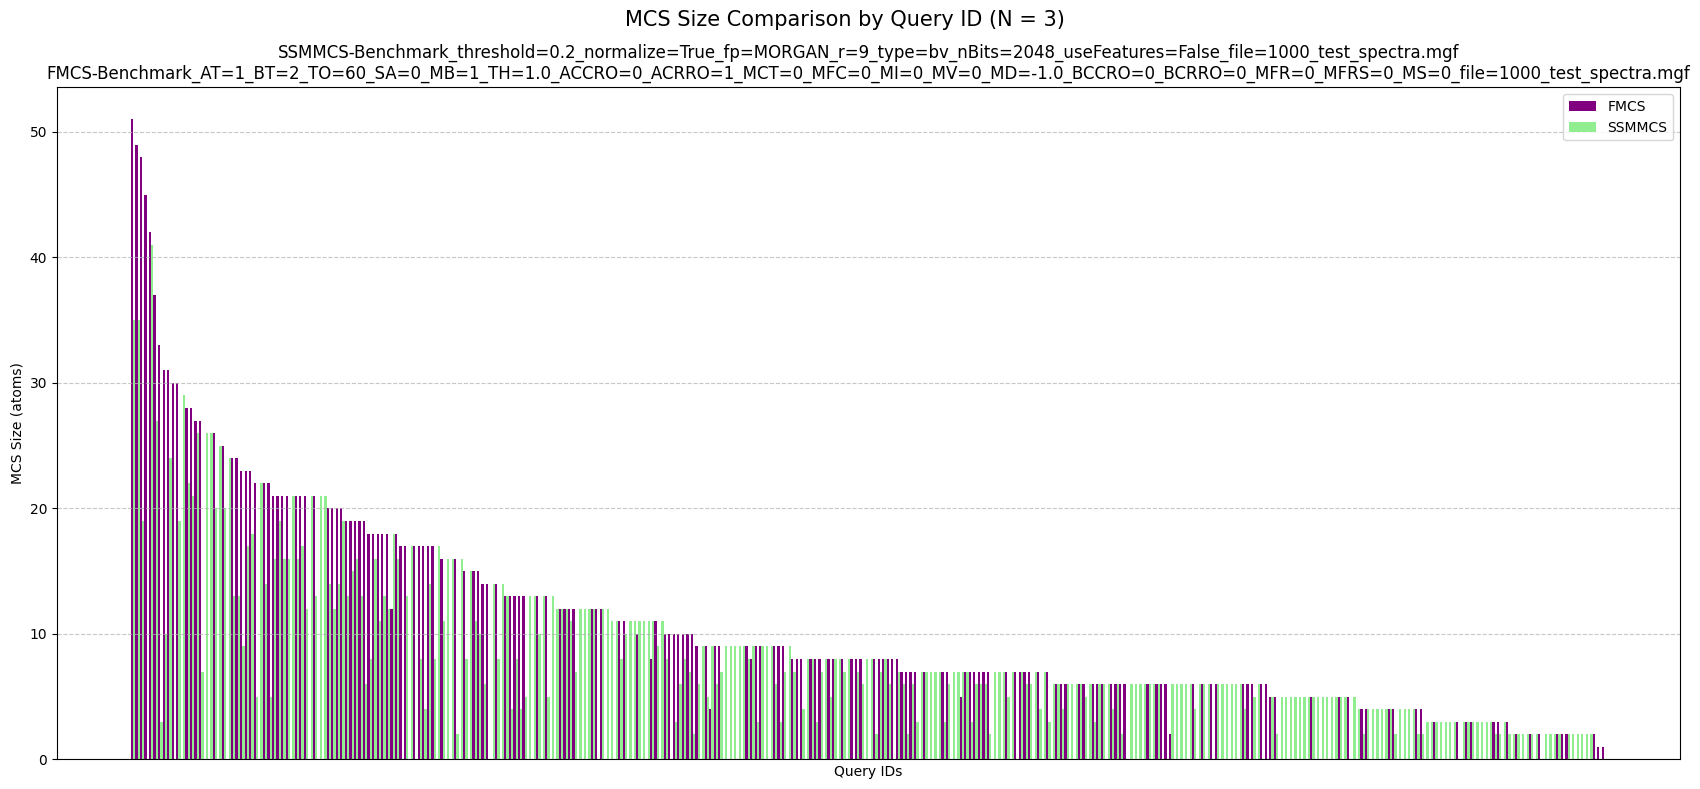

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Get all unique query IDs from both dataframes
all_query_ids = set(fmcs_df["query_id"]).union(set(ssmmcs_df["query_id"]))

# Create a dataframe to hold the comparison data
comparison_df = pd.DataFrame(columns=["query_id", "fmcs_size", "ssmmcs_size"])

# Populate the comparison dataframe for all query IDs
for qid in all_query_ids:
    # Get FMCS size if available
    fmcs_row = fmcs_df[fmcs_df["query_id"] == qid]
    fmcs_size = fmcs_row["mcs_size"].values[0] if len(fmcs_row) > 0 and fmcs_row["matched"].values[0] else 0
    
    # Get SSMMCS size if available
    ssmmcs_row = ssmmcs_df[ssmmcs_df["query_id"] == qid]
    ssmmcs_size = ssmmcs_row["mcs_size"].values[0] if len(ssmmcs_row) > 0 and ssmmcs_row["matched_mcs"].values[0] else 0
    
    # Add to dataframe only if at least one method found a match
    if fmcs_size > 0 or ssmmcs_size > 0:
        new_row = {
            "query_id": qid,
            "fmcs_size": fmcs_size,
            "ssmmcs_size": ssmmcs_size,
            "difference": ssmmcs_size - fmcs_size
        }
        comparison_df = pd.concat([comparison_df, pd.DataFrame([new_row])], ignore_index=True)

# Sort by maximum MCS size (either method) for better visualization
comparison_df["max_size"] = comparison_df[["fmcs_size", "ssmmcs_size"]].max(axis=1)
comparison_df = comparison_df.sort_values("max_size", ascending=False)

# Setting up the bar chart with side-by-side bars
bar_width = 0.5
x = np.arange(len(comparison_df))

fig, ax = plt.subplots(figsize=(17, 8))

# Creating the bars - only show bars for non-zero values
bar1 = ax.bar(
    x - bar_width / 2,
    comparison_df["fmcs_size"],
    bar_width,
    label="FMCS",
    color="purple",
)
bar2 = ax.bar(
    x + bar_width / 2,
    comparison_df["ssmmcs_size"],
    bar_width,
    label="SSMMCS",
    color="lightgreen",
)

# Add labels, title and legend
ax.set_xlabel("Query IDs")
ax.set_ylabel("MCS Size (atoms)")
fig.suptitle(f"MCS Size Comparison by Query ID (N = {cse_fmcs_params.n})", fontsize=15)
ax.set_title(f"{cse_ssmmcs_params.method_params.__str__()}\n{cse_fmcs_params.method_params.__str__()}")
ax.set_xticks([])
ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.legend()

plt.tight_layout()
plt.savefig(
    os.path.join(
        DATA_FOLDER,
        f"mcs_size_comparison_by_query_id_(all_mcs)_n={cse_fmcs_params.n}_ssmmcs_vs_fmcs.png",
    ),
    dpi=300,
)
plt.show()

In [32]:
benchmark_df = pd.DataFrame(
    columns=[
        "method",
        "matched_ratio",
        "avg_mcs_size",
        "computation_time",
        "matched_query_ids",
        "aborted_query_ids",
        "mcs_sizes",
        "mcs_matches",
    ]
)

csv_file = os.path.join(DATA_FOLDER, f"benchmark_results_for_{FILENAME} - n={N}.csv")
benchmark_df.to_csv(csv_file, index=False)
print(f"Benchmark results saved to {csv_file}")

Benchmark results saved to data\benchmark_results_for_1000_test_spectra.mgf - n=3.csv


In [33]:
benchmark_df

,method,matched_ratio,avg_mcs_size,computation_time,matched_query_ids,aborted_query_ids,mcs_sizes,mcs_matches


In [34]:
import rdkit.Chem.Draw as Draw


query_id = 0

Draw.MolToImage(
    query_mols[query_id]
)  # , highlightAtoms=mcs_matches_FMCS[query_id], size=(300, 300))
fmcs = rdFMCS.FindMCS(get_query_analogues(query_id), fmcs_params.params)
fmcs_dict = fmcs.degenerateSmartsQueryMolDict

In [35]:
fmcs_params.params.StoreAll = False
benchmark_fmcs(query_mols[query_id : query_id + 1], fmcs_params)

Benchmarking FMCS:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\kevin\AppData\Local\Temp\ipykernel_17992\785843244.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fmcs_df = pd.concat([fmcs_df, pd.DataFrame([new_row])], ignore_index=True)


,query_id,matched,failed,time,mcs_size,mcs_smarts,query_match,degenerate_smarts
0,0,True,False,0.002999,42,[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R]-[#6&!R...,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",None


In [36]:
# This causes the RuntimeError:
# FMCS. Invalid argument. mols.size() must be at least 2:
# maximum_common_substruct = rdFMCS.FindMCS(get_query_analogues(query_id), params)
# TODO: Why has this thing only 2 analogues? Also why do all the analogues only have 1 query id? Shouldn't some analogues have multiple? Query_ID should be Query_IDs and might be buggy.

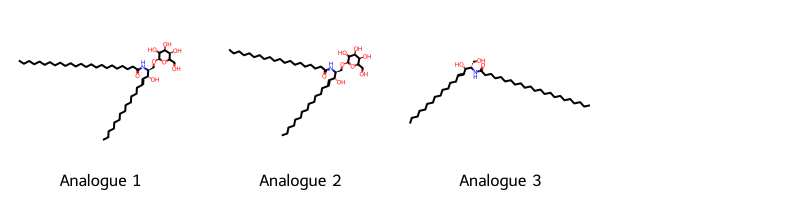

In [37]:
Draw.MolsToGridImage(
    get_query_analogues(query_id),
    molsPerRow=4,
    legends=[f"Analogue {i+1}" for i in range(N)],
)